In [1]:
import cellrank as cr
import scanpy as sc
import scvelo as sv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [3]:
summary_tab = pd.DataFrame(columns = ('Method', 'Dataset', 'Celltype', 'Mean Probability'))

In [4]:
datasets = ['Pancreas_with_cc', 'DentateGyrus' , 'MouseBoneMarrow', 'MouseErythroid', 'HumanBoneMarrow']
methods = ['cell2fate', 'scVelo', 'DeepVelo', 'CellDancer', 'pyroVelocity_model1', 'scVelo_stochastic', 'pyroVelocity_model2', 'VeloVI', 'VeloVAE', 'UniTVelo_unified', 'UniTVelo_independent']

In [5]:
correct_fates_dict = {'DentateGyrus': 
                 {'Astrocytes': ('Astrocytes', 'Radial_Glia-like'),
                 'OL': ('OPC', 'OL'),
                 'Granule_mature': ('Granule_mature', 'Radial Glia-like', 'Granule_immature', 'nIPC', 'Neuroblast')},
                 'Pancreas_with_cc':    
                 {'Alpha': ('Alpha'),
                 'Beta': ('Beta'),
                 'Delta': ('Delta'),
                 'Epsilon': ('Epsilon')},
                  'MouseErythroid':    
                 {'Erythroid3': ('Erythroid2', 'Erythroid1', 'Blood_progenitors_2', 'Blood_progenitors_1')},
                 'HumanBoneMarrow':    
                 {'CLP': ('CLP'),
                 'Mono_1': ('Mono_1', 'Mono_2'),
                 'DCs': ('DCs'),
                 'Ery_2': ('Ery_2', 'Ery_1'),
                 'Mega': ('Mega')},
                 'MouseBoneMarrow':                  
                 {'activating': ('activating', 'progenitors', 'dividing')}}

Computing transition matrix using `'deterministic'` model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9815/9815 [00:02<00:00, 3576.92cell/s]

Using `softmax_scale=4.5924`



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9815/9815 [00:02<00:00, 3920.64cell/s]

    Finish (0:00:05)
Projecting transition matrix onto `umap`


Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:02)


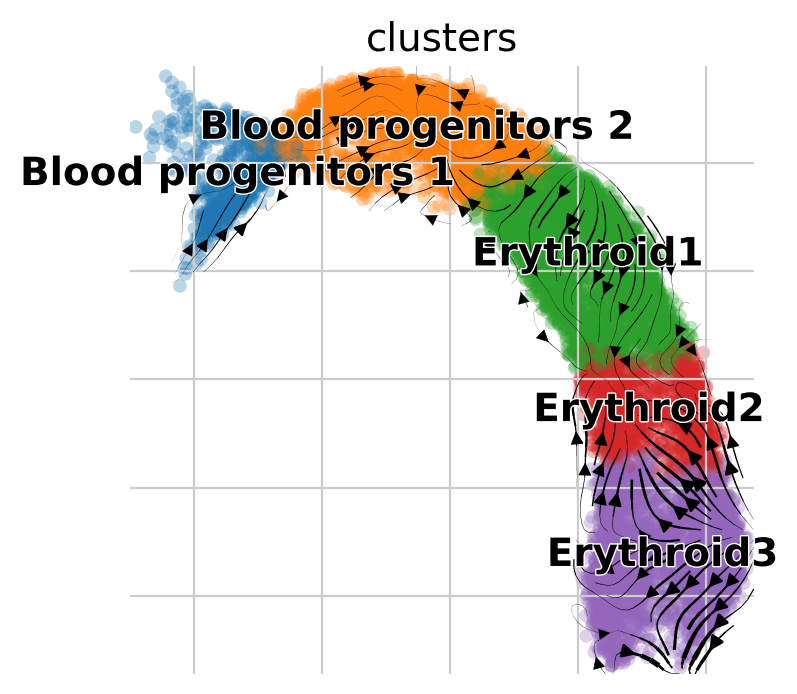

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[9]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Calculating minChi criterion in interval `[4, 11]`
Computing `7` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)
macrostates ['Blood_progenitors_1_1', 'Blood_progenitors_1_2', 'Erythroid3_1', 'Erythroid3_2', 'Blood_progenitors_2', 'Erythroid1', 'Erythroid2']


In [6]:
i = 3
j = 8
# Load data
adata = sc.read_h5ad('/nfs/team283/aa16/data/fate_benchmarking/CellRank/' + methods[j] + datasets[i] + 'AnnDataForCellRank.h5ad')
# Removing underscore makes cluster names compatabile with CellRank:
adata.obs['clusters'] = [x.replace(" ", "_") for x in adata.obs['clusters']]
# Run cellrank:
from cellrank.kernels import VelocityKernel
correct_fates = correct_fates_dict[datasets[i]]
vk = VelocityKernel(adata, velocity_key="velocity")
vk.compute_transition_matrix()
vk.plot_projection()
g = cr.estimators.GPCCA(vk)
# Try finding macrostates with default parameters and if there is an error reduce maximal number by 1 and try again
max_states = 11
n_states = [4, max_states]
g.fit(cluster_key="clusters", n_states= n_states)
macrostates = list(g.macrostates.value_counts().index)
print('macrostates', macrostates)

In [7]:
terminal_states = ['Blood_progenitors_1_1', 'Erythroid3_1']
g.set_terminal_states(states=terminal_states)
g.compute_fate_probabilities(solver = 'direct')

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities
Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:14)


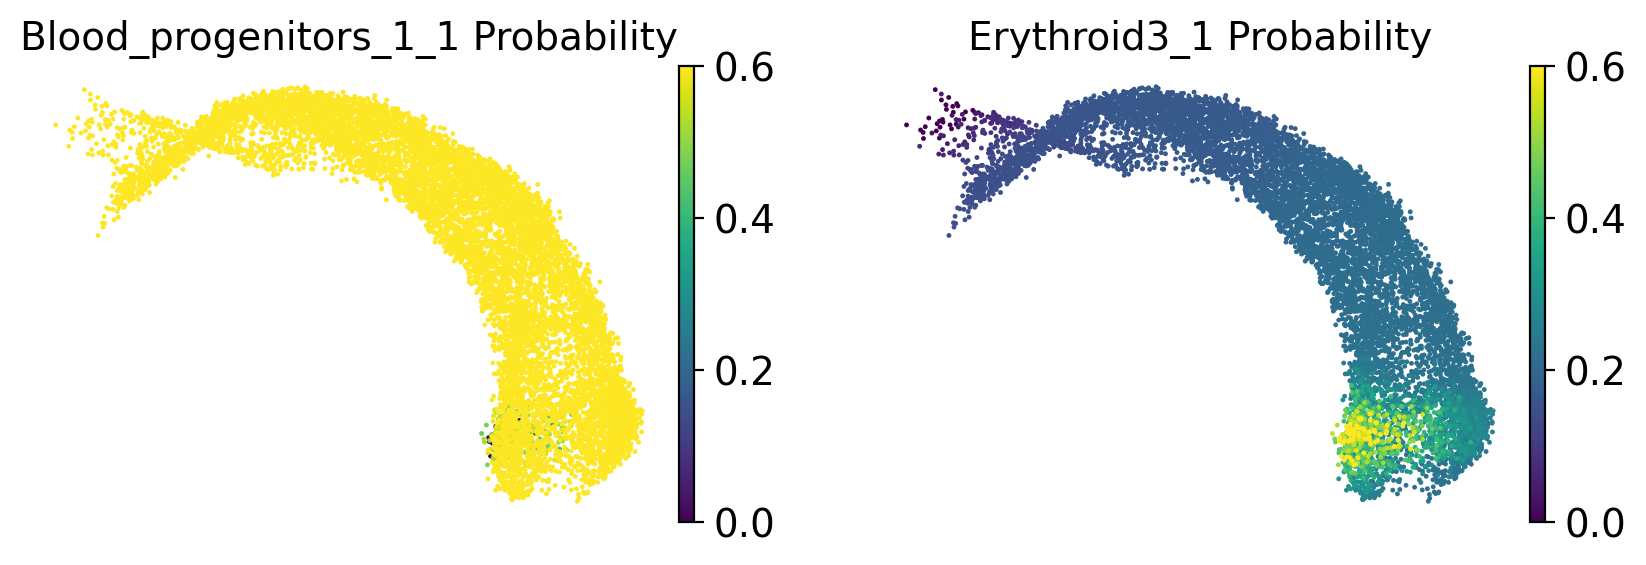

In [8]:
for k in range(len(terminal_states)):
    try:
        adata.obs[terminal_states[k] + ' Probability'] = np.array(g.fate_probabilities[terminal_states[k]])
    except:
        adata.obs[terminal_states[k] + ' Probability'] = 0
fig, ax = plt.subplots(1, len(terminal_states), figsize = (5*len(terminal_states), 3))
for k in range(len(terminal_states)):
    sc.pl.umap(adata, color = terminal_states[k] + ' Probability', vmax = 0.6, ax = ax[k], show = False)
plt.savefig('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/CellRank/' + methods[j] + datasets[i] + '.pdf')

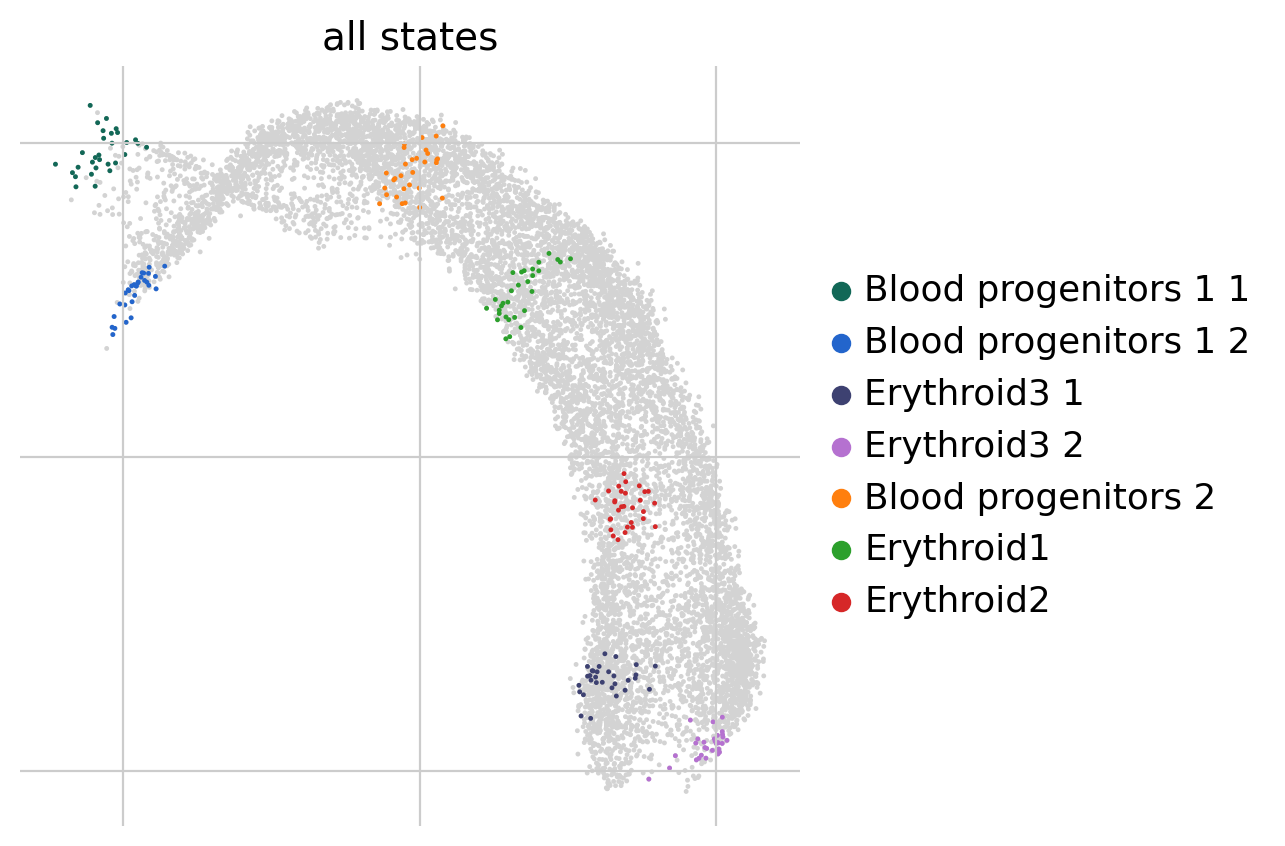

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
g.plot_macrostates(which="all", ax = ax, show = False, legend_loc = 'right margin')
plt.savefig('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/CellRank/' + methods[j] + datasets[i] + 'terminalStates.pdf',
           bbox_inches='tight')